## 1. Problem
Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips.

#2. Machine Learning Pipeline
**Input-** images of rice and chips

**Output-** label of 0 (Chips) or 1(Rice)

**The stages are**

**1. Data Collection-**Mounting Google Drive to access and save data.
Downloading a dataset called "MLEndYD" using the download_yummy function from mlend. This dataset contains information about food images, including image attributes and labels in a csv file.

**2. Data-preprocessing-**Loading the dataset into a DataFrame (MLENDYD_df) and creating a new column 'Label' based on conditions, identifying images as either "Chips" (0) or "Rice" (1).
Removing rows with conflicting labels and irrelevant information.
Splitting the dataset into training and testing sets.

**3. Feature extraction-**Extracting features from the preprocessed images, including the yellow component and Gray Level Co-occurrence Matrix (GLCM) features.
Normalizing the features using mean and standard deviation.

**4. Handling class imbalance-**Addressing class imbalance using the Synthetic Minority Over-sampling Technique (SMOTE) to balance the training dataset.

**5. Data augmentation-**Augmenting the training dataset with additional transformations, such as random rotation and flipping, to enhance model generalization.

**6. Model training-** Training a Decision Tree classifier from scikit-learn with specified hyperparameters (max depth, min samples split) on the augmented and balanced training set.

**7. Evaluation-**Evaluating the trained model on both the training and test sets using accuracy metrics.
Displaying a confusion matrix for the test set to visualize model performance.

**8. Testing on random images-**Defining a function (test_model_on_random_images) to randomly select images from the test set, preprocess them, extract features, standardize, and predict using the trained model. It then displays the true and predicted labels along with the images.

Importing required libraries

In [ ]:
!pip install mlend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install mlend --upgrade

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy_small, yummy_small_load

import os, sys, re,glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


# 3. Dataset
The dataset is MLEnd Yummy.It consists of enriched images of food from diverse cuisines. It is dowloaded and saved in a folder called MLEnd in the google drive.

In [ ]:
import mlend
from mlend import download_yummy, yummy_load

subset = {}

datadir = download_yummy(save_to = '/content/drive/MyDrive/Data/MLEnd', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


Reading the data from the csv file into a data frame

In [ ]:
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv')
MLENDYD_df

,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
0,000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
1,000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
2,000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
3,000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
4,000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...
3245,003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
3246,003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
3247,003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test
3248,003249.jpg,vegan,indian,indian,fruit_milk,home,"kiwi,banana,apple,milk",very_healthy,5.0,strongly_like,5.0,Train


About the data:
The dataframe contains 3250 rows and 12 columns.

Since we need the images of rice and chips only, we subset the data on some given conditions to extract images that contain only rice and chips and discard the rest. We also create a new column called Label which contains the values 1(for Rice) and 0(for Chips)

In [ ]:
import pandas as pd


# Create a new column 'Label' based on conditions
def label_images(row):
    dish_name = row['Dish_name'].lower() # converting to lower case
    ingredients = row['Ingredients'].lower() #converting to lower case

    # Check if it's a rice row
    if 'rice' in dish_name or 'rice' in ingredients:
        return 1
    # Check if it's a chips row
    elif 'chips' in dish_name or 'chips' in ingredients or 'fries' in dish_name or 'fries' in ingredients: # here we consider fries also as chips
        return 0
    else:
        return -1  # You can use -1 for rows that don't match rice or chips

# Create the 'Label' column
MLENDYD_df['Label'] = MLENDYD_df.apply(label_images, axis=1)

# Remove rows containing both rice and chips, and rows with 'choco chips' in ingredients as they cannot be taken as chips
MLENDYD_df = MLENDYD_df[~((MLENDYD_df['Label'] == 1) & (MLENDYD_df['Label'] == 0))]
MLENDYD_df = MLENDYD_df[~MLENDYD_df['Ingredients'].str.contains('choco chips', case=False, na=False)]
MLENDYD_df = MLENDYD_df[MLENDYD_df['Label'] != -1]
# Display the DataFrame
MLENDYD_df


,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Label
0,000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,1
15,000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,1
19,000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,1
20,000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,1
21,000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3234,003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,1
3235,003236.jpg,non_vegetarian,german/turkish,german_turkish,german_doner_kebab,gdk,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",unhealthy,2.0,strongly_like,5.0,Train,0
3242,003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,1
3243,003244.jpg,vegetarian,italian,italian,khichdi,home,"rice,split_yellow_mung_beans,salt,cumin_seeds,...",healthy,4.0,neutral,3.0,Train,1


After running the above code cell we get a subset of the original dataset. This new set contains only data about rice and chips. Now the dataset is reduced from 3250 rows to 947 rows. Further the new column 'Label' is also added.

# Creating Train and Test Data

In [ ]:
# Assuming 'Benchmark_A' column contains values 'train' and 'test'
train_data = MLENDYD_df[MLENDYD_df['Benchmark_A'] == 'Train']
test_data = MLENDYD_df[MLENDYD_df['Benchmark_A'] == 'Test']

# Display the shapes of the training and testing datasets
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)


Training Data Shape: (651, 13)
Testing Data Shape: (296, 13)


We split the data according to the Label of Train or Test present in the Benchmark_A column of the dataframe. The obtained train data has 651 rows and 13 columns and the obtained test data has 296 rows and 13 columns

In [ ]:
train_data

,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Label
0,000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,1
20,000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,1
21,000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,1
23,000024.jpg,vegan,british,british,pie_and_chips,home,"mushroom_pie,chips,peas",neutral,3.0,like,4.0,Train,0
25,000026.jpg,non_vegetarian,pakistani,pakistani,chicken_biryani,home,"rice,chicken,biryani_masala,yogurt,oil,green_c...",healthy,4.0,strongly_like,5.0,Train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,003232.jpg,vegan,indian,indian,daal_rice,home,"yellow_lentils,onion,ginger,garlic,cumin_seeds...",healthy,4.0,neutral,3.0,Train,1
3235,003236.jpg,non_vegetarian,german/turkish,german_turkish,german_doner_kebab,gdk,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",unhealthy,2.0,strongly_like,5.0,Train,0
3242,003243.jpg,vegetarian,british,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,1
3243,003244.jpg,vegetarian,italian,italian,khichdi,home,"rice,split_yellow_mung_beans,salt,cumin_seeds,...",healthy,4.0,neutral,3.0,Train,1


Further splitting the data into X_train,Y_train,X_test,Y_test

In [ ]:
X_train_paths=train_data['filename'].apply(lambda x: f'/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/{x}').tolist()
Y_train=train_data['Label'].tolist()
X_test_paths=test_data['filename'].apply(lambda x: f'/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/{x}').tolist()
Y_test=test_data['Label'].tolist()

The training data should contain images, which will be stored in X_train and X_test. The labels will be stored in Y_train and Y_test. Since in our dataframe we have paths to the images, we extract these images using their paths in the next step.We store the path names in X_train_paths and X_test_paths. We store the labels in Y_train and Y_test.

#Data Pre-processing

In the cell below we check the counts for each class to check if there is any imbalance in the data

In [ ]:
# Check the counts of each class in the training set
class_counts_train = pd.Series(Y_train).value_counts()

# Display the class counts
print("Class Counts in Training Set:")
print(class_counts_train)


Class Counts in Training Set:
1    553
0     98
dtype: int64


We can see that the dataset is clearly imbalanced as there are more class 1 samples(Rice) as compared to class 0 samples(Chips)

#Visualizing dishes

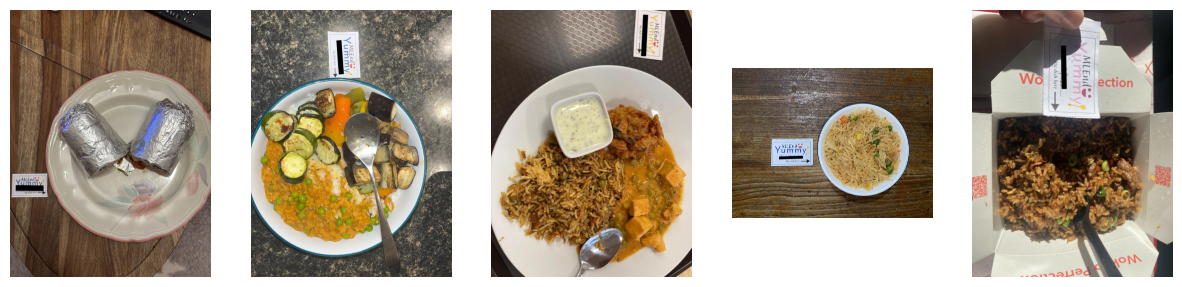

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Select a random subset of images for visualization
num_images_to_visualize = 5
sample_indices = random.sample(range(len(X_train_paths)), num_images_to_visualize)

# Plot the selected images
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    image_path = X_train_paths[idx]
    label = Y_train[idx]

    # Load and display the image
    img = mpimg.imread(image_path)

    plt.subplot(1, num_images_to_visualize, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()


we can clearly see that the images are of different sizes and hence we need to resize them

The code below is used to resize the images and convert each one to one size to ensure standardization

In [ ]:
# Function to make an image square by padding
def make_it_square(I, pad=0):
    N, M, C = I.shape
    # If height is greater than width, pad the width
    if N > M:
        Is = [np.pad(I[:, :, i], [(0, 0), (0, N - M)], 'constant', constant_values=pad) for i in range(C)]
    # If width is greater than height, pad the height
    else:
        Is = [np.pad(I[:, :, i], [(0, M - N), (0, 0)], 'constant', constant_values=pad) for i in range(C)]

    return np.array(Is).transpose([1, 2, 0])

# Function to resize an image to a specified size
def resize_img(I, size=[100, 100]):
    N, M, C = I.shape
    # Resize each channel separately
    Ir = [sp.core.processing.resize(I[:, :, i], size) for i in range(C)]
    return np.array(Ir).transpose([1, 2, 0])

# Resize and preprocess images for the training set
X_train = []
for k, file in enumerate(X_train_paths):
    sp.utils.ProgBar_JL(k, len(X_train_paths), L=50, color='blue')# Display progress bar

    I = plt.imread(file) # Read image using matplotlib
    I = make_it_square(I, pad=0)  # Make the image square by padding
    I = resize_img(I, size=[200, 200]) # Resize the image to the specified size
    X_train.append(I)# Append the preprocessed image to the training set

# Resize and preprocess images for test set
X_test = []
for k, file in enumerate(X_test_paths):
    sp.utils.ProgBar_JL(k, len(X_test_paths), L=50, color='blue')  # Display progress bar
    I = plt.imread(file) # Read image using matplotlib
    I = make_it_square(I, pad=0) # Make the image square by padding
    I = resize_img(I, size=[200, 200]) # Resize the image to the specified size
    X_test.append(I) # Append the preprocessed image to the test set

X_train = np.array(X_train)
X_test = np.array(X_test)
print("Resized Training Set Shape:", X_train.shape)
print("Resized Test Set Shape:", X_test.shape)


100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|651\651|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|296\296|
Done!
Resized Training Set Shape: (651, 200, 200, 3)
Resized Test Set Shape: (296, 200, 200, 3)


After resizing we have have 651 images, each of size 200x200 pixels, with three color channels. Similarly, the shape (296, 200, 200, 3) for the resized test set indicates that we have 296 test images with the same characteristics.

Visualizing the resized dishes

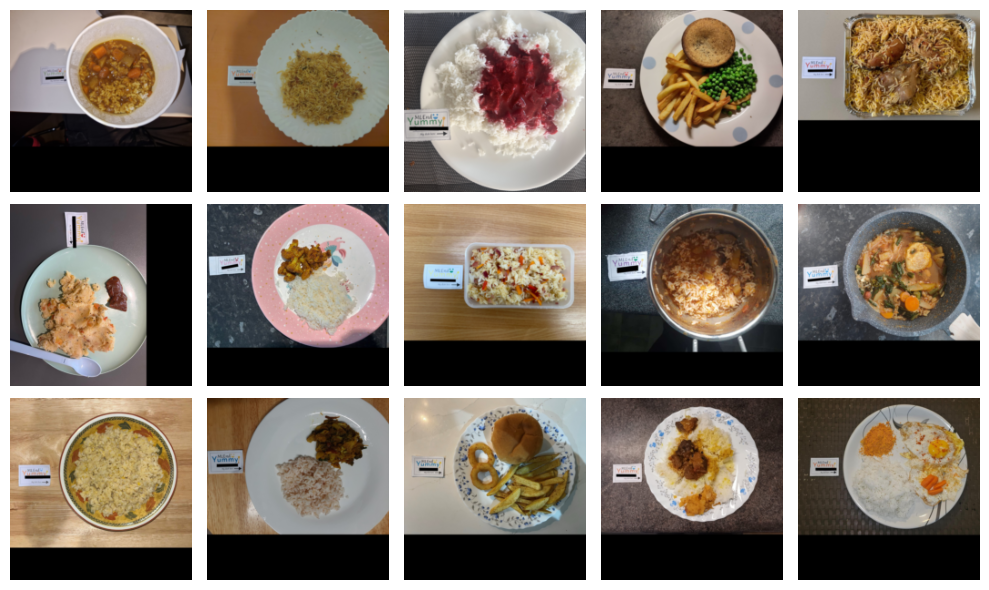

In [ ]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

Now we can see that all images are of the same size

#4. Transformation Stage

# Feature Extraction
 Each photo is represented by 3 x 200 x 200 = 120,000 values, resulting in a predictor space with 120,000 dimensions. Training a model on such a high-dimensional space necessitates a training dataset with more than 120,000 samples, which exceeds the size of our current dataset.
 Thus we need to transform our samples from a 120,000-dimensional space to another space with fewer dimensions. Feature extraction emerges as a practical approach to achieve this dimensionality reduction.
 Here we extract the colour features and texture features and obtain 3 features in total.

In [ ]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops

# Function to extract the yellow component from an image
def get_yellow_component(I, t1=27, t2=33):
    # Convert the image to HSV color space and extract the yellow component
    Ihsv = (rgb2hsv(I) * 255).astype('uint8')
    # Create a mask for pixels within the specified hue range for yellow
    mask = (Ihsv[:, :, 0] < t2) * (Ihsv[:, :, 0] > t1)
    # Count the number of yellow pixels in the mask
    Ypx = mask.sum()
    return Ypx

# Function to compute Gray Level Co-occurrence Matrix (GLCM) features
def GMLC_features(I):
    # Convert the image to grayscale
    Ig = (rgb2gray(I) * 255).astype('uint8')
    # Compute GLCM with specified parameters
    glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    # Extract dissimilarity and correlation features from GLCM
    f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
    f2 = graycoprops(glcm, 'correlation')[0, 0]
    return f1, f2

# Function to display a confusion matrix
def showConfMat(CM, labels=['Chips', 'Rice']):
    # Display the confusion matrix using matplotlib
    plt.matshow(CM, cmap='Blues')
    # Display the values inside the cells of the matrix
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            plt.text(i, j, CM[i, j].round(2), ha='center',)
    # Set the labels for x and y axes
    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels)
    # Show the plot
    plt.show()


In the cell below we just call the functions defined above to extract the features.

In [ ]:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_train_f.append([f1,f2,f3])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_test_f.append([f1,f2,f3])

In [ ]:
print(X_train_f)


[[701, 11.307794871794876, 0.9460024112690486], [3559, 6.478000000000001, 0.966182848079513], [6647, 19.940512820512822, 0.8669915154994423], [1249, 19.181923076923077, 0.85608631659485], [3779, 16.043846153846154, 0.9008739418619839], [274, 18.25102564102564, 0.8422899141249912], [1646, 13.37417948717949, 0.9296095638026028], [1938, 10.77361538461538, 0.9442216142443107], [219, 16.947666666666667, 0.8681948512107311], [1402, 16.049256410256415, 0.8860657783937276], [9057, 15.554948717948722, 0.896614957453547], [352, 8.75997435897436, 0.9534128483954264], [6403, 12.432205128205132, 0.9452690467514242], [2114, 14.664923076923076, 0.915438378073965], [5128, 12.067666666666666, 0.9174390974356683], [6356, 22.22543589743589, 0.8335533783327835], [970, 10.211794871794872, 0.9521260855197682], [1135, 16.867717948717946, 0.815327881199451], [1597, 16.86502564102564, 0.8835043337818923], [581, 18.765487179487177, 0.8507717489785938], [5326, 15.33861538461539, 0.8775305057920031], [2445, 14.02

In [ ]:
print(X_test_f)

[[1419, 20.010897435897434, 0.887919105244046], [2029, 16.05389743589744, 0.9052621963794937], [10267, 7.7452564102564105, 0.9710714998724032], [2274, 16.394820512820512, 0.9196924985554403], [8746, 26.97566666666667, 0.7901519475752974], [577, 13.659589743589745, 0.9303898525611591], [3433, 13.913435897435901, 0.925437327442628], [2337, 13.459025641025642, 0.9146357873523756], [1361, 16.64574358974359, 0.8830540504994489], [8892, 14.968923076923078, 0.9061327707987689], [1198, 8.110153846153846, 0.9493816314777092], [3294, 20.198179487179488, 0.8511308773837761], [2627, 20.936641025641027, 0.7959758472675379], [4666, 13.614615384615384, 0.9191216094508191], [4584, 9.809435897435899, 0.8371986930455703], [10210, 15.220743589743588, 0.894257613488156], [1038, 21.68669230769231, 0.8484121562111478], [13601, 17.326384615384622, 0.8781999389065219], [4885, 18.2554358974359, 0.8976725598035575], [11591, 7.4811025641025655, 0.9816266440152754], [8123, 12.220282051282052, 0.9368710809625289],

Output:each list in the above output represents a sample, and the three values within each list correspond to a color component feature, and
 2 texture feature, respectively. These features will be used as input to train the selected machine learning model.

The cell below converts the above 2 lists to a np array which will be input for the subsequent stages

In [ ]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((651, 3), (296, 3))

The training set of features (X_train_f) has 651 samples (images).
Each sample is described by 3 features.
The test set of features (X_test_f) has 296 samples (images).
Each sample is also described by 3 features.

# Normalization
the code below normalizes the features by centering them around zero and scaling them to have a standard deviation of 1, enhancing the numerical stability and convergence of machine learning models.

In [ ]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

The code normalizes the training features (X_train_f) and the testing features by subtracting the mean (MEAN) and dividing by the standard deviation (SD). This ensures that each feature has a mean of 0 and a standard deviation of 1 across the training set.


#Handling data imbalance

In [ ]:
from imblearn.over_sampling import SMOTE

# Assuming X_train_fn, Y_train, X_test_fn are defined as before

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_fn, Y_train)

# Check the counts of each class after SMOTE
class_counts_balanced = pd.Series(Y_train_balanced).value_counts()

# Display the class counts after SMOTE
print("\nClass Counts in Balanced Training Set (after SMOTE):")
print(class_counts_balanced)



Class Counts in Balanced Training Set (after SMOTE):
1    553
0    553
dtype: int64


The reason for using SMOTE is to address the issue of imbalanced class distribution in the dataset.
In imbalanced datasets, where one class is significantly underrepresented compared to another, machine learning models may struggle to learn patterns from the minority class.
Hence, the code applies SMOTE to the training data to address imbalanced class distribution, and it checks and displays the class counts after the application of SMOTE.
The output shows that, after applying SMOTE, both classes (0 for 'Chips' and 1 for 'Rice') now have an equal number of samples (553 each), resulting in a balanced training set.

#Data Augmentation

In [ ]:
from skimage import transform, util

# Data augmentation function with more transformations
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)

        # Check if the image is 3D or 2D
        if len(image.shape) == 3:
            # Apply larger random rotation to each channel
            rotated_images = [transform.rotate(image[:, :, i], angle=np.random.uniform(-20, 20), mode='reflect') for i in range(image.shape[2])]
            rotated_image = np.stack(rotated_images, axis=-1)
            augmented_images.append(rotated_image)
            augmented_labels.append(label)

            # Apply random flipping to each channel
            flipped_images = [util.random_flip(rotated_image[:, :, i], horizontal=True, vertical=False) for i in range(rotated_image.shape[2])]
            flipped_image = np.stack(flipped_images, axis=-1)
            augmented_images.append(flipped_image)
            augmented_labels.append(label)
        elif len(image.shape) == 2:
            # Apply larger random rotation
            rotated_image = transform.rotate(image, angle=np.random.uniform(-20, 20), mode='reflect')
            augmented_images.append(rotated_image)
            augmented_labels.append(label)

            # Apply random flipping
            flipped_image = util.random_flip(rotated_image, horizontal=True, vertical=False)
            augmented_images.append(flipped_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

The function takes a set of images (images) and their corresponding labels (labels) as input. For each image-label pair, the original image and label are added to the augmented dataset.The function returns the augmented images and labels as NumPy arrays.
Data augmentation function introduces variations to the training images, promoting dataset diversity and improving the model's ability to generalize and perform well on unseen data.


In [ ]:
X_train_aug,Y_train_aug=augment_data(X_train_balanced,Y_train_balanced)
# Shuffle the augmented data
X_train_aug, Y_train_aug = shuffle(X_train_aug, Y_train_aug, random_state=42)

In [ ]:
X_train_aug

array([[-0.59680232,  0.9706325 , -0.12633808],
       [-0.51483918, -0.14714131, -0.37873937],
       [ 1.43806618,  0.96978213, -0.2611033 ],
       ...,
       [ 0.02418333,  0.60727542, -0.38453699],
       [-0.91745984,  0.69264864, -0.60633146],
       [ 0.61494287,  0.69420136, -0.85427535]])

The augment_data function takes the balanced training images (X_train_balanced) and their corresponding labels (Y_train_balanced) as input. It generates augmented images and labels, incorporating larger random rotations and random flipping. The resulting augmented training set is stored in X_train_aug and Y_train_aug.To introduce randomness during training and prevent any potential bias, the augmented data is shuffled using the shuffle function.

#5. Modelling

A **decision tree** is a machine learning algorithm used for both classification and regression tasks. It works by recursively partitioning the dataset into subsets based on the values of input features, making decisions at each node to reach a final prediction. Additionally, they can effectively handle both numeric and categorical features without requiring extensive preprocessing which is the prime reason for selecting decision tree as the model for this problem.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
decision_tree_model = DecisionTreeClassifier(random_state=42,max_depth=3,min_samples_split=5)
decision_tree_model.fit(X_train_aug, Y_train_aug)

DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)

#6.  Methodology

# Predictions and Evaluations

Decision Tree Training Accuracy:	 0.7142857142857143
Decision Tree Test Accuracy:	 0.6655405405405406


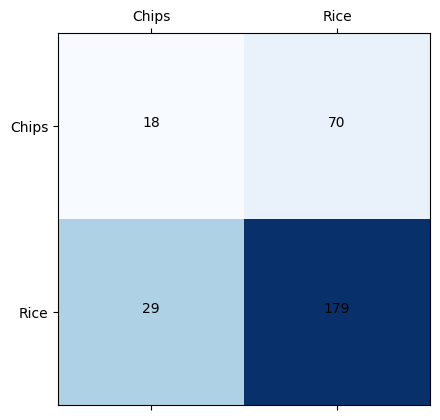

In [ ]:
# Predictions on the training set
y_train_pred = decision_tree_model.predict(X_train_fn)

# Predictions on the test set
y_test_pred = decision_tree_model.predict(X_test_fn)

# Evaluate the model
train_accuracy_dt = accuracy_score(Y_train, y_train_pred)
test_accuracy_dt = accuracy_score(Y_test, y_test_pred)

print('Decision Tree Training Accuracy:\t', train_accuracy_dt)
print('Decision Tree Test Accuracy:\t', test_accuracy_dt)

# Display confusion matrix for test set
conf_mat_dt = confusion_matrix(Y_test, y_test_pred)
showConfMat(conf_mat_dt, labels=['Chips', 'Rice'])

Interpretation-

True Positives (TP): 179

True Negatives (TN): 18

False Positives (FP): 70

False Negatives (FN): 29

The model performs reasonably well in identifying the 'Rice' class (True Positives: 179) but struggles with the 'Chips' class, especially with a higher number of false positives (70).



# 7. Results

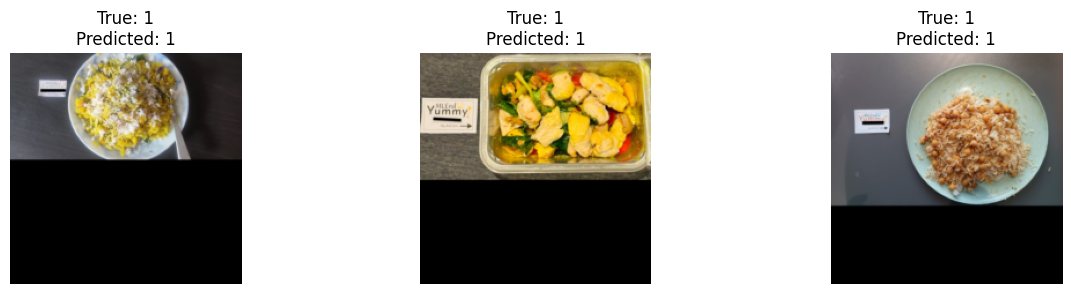

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def test_model_on_random_images(model, X_paths, Y_true, num_images=5):
    # Select random images
    random_indices = np.random.choice(len(X_paths), num_images, replace=False)

    # Initialize subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        image_path = X_paths[idx]
        true_label = Y_true[idx]

        # Load and display the image
        img = mpimg.imread(image_path)

        # Preprocess the image (similar to the training process)
        img = make_it_square(img, pad=0)
        img = resize_img(img, size=[200, 200])

        # Extract features (similar to the training process)
        f1 = get_yellow_component(img)
        f2, f3 = GMLC_features(img)
        img_features = np.array([[f1, f2, f3]])

        # Standardize the features
        img_features_std = (img_features - MEAN) / SD

        # Predict using the model
        predicted_label = model.predict(img_features_std)[0]

        # Display the image and its predicted classification
        axes[i].imshow(img)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        axes[i].axis('off')

    plt.show()

# Use the function to test the model on random images
test_model_on_random_images(decision_tree_model, X_test_paths, Y_test, num_images=3)


From the above output we can see right classification of the input dishes according to the predicted output using decision tree.

# 8. Conclusion

1. Since the data was imbalanced and i have used smote, other techniques like undersampling could be used and the results can be explored based on class wise predictions.
2. The lower precision and recall for the 'Chips' class is an area for improvement.
3. Different feature extraction techniques could be explored to obtain different and better results.
4. Apart from data augmentation, techniques like feature engineering could be used to improve model performance.
5. Different models can be explored to see which one works best for this problem.